In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


# from sklearn.decomposition import PCA
from scipy import stats
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# from sklearn.metrics import davies_bouldin_score

import pickle
import copy
# from shapely import geometry
# from sklearn.metrics.pairwise import euclidean_distances
# import statsmodels.api as sm
from scipy.stats import linregress
# from sklearn.metrics import accuracy_score
import math
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# from scipy.stats import ks_2samp

In [2]:
import string
abcd = list(string.ascii_lowercase)

In [3]:
def shift_longitude_to_0_360(dataset):
    """
    Shifts the longitudes of an xarray Dataset from [-180, 180] to [0, 360].

    Args:
        dataset (xr.Dataset): The input Dataset with 'lon' coordinates.

    Returns:
        xr.Dataset: The Dataset with shifted longitudes.
    """

    # Identify negative longitudes
    negative_lons = dataset['lon'].values < 0

    # Shift negative longitudes
    shifted_lons = dataset['lon'].values.copy()
    shifted_lons[negative_lons] += 360

    # Reassign coordinates
    shifted_dataset = dataset.assign_coords(lon=shifted_lons)

    # Reorder (optional, if needed)
    shifted_dataset = shifted_dataset.sortby('lon')

    return shifted_dataset

# Example usage (assuming your Dataset is named 'my_dataset'):
# shifted_dataset = shift_longitude_to_0_360(my_dataset)

# sst

In [4]:
corr_sst = xr.open_dataset('../SST_AOD/correlations_obs/corr_sst_v2.nc')
arr_temp = corr_sst.correlation.values
arr_temp[corr_sst.p_value.values>=0.05] = np.nan
corr_sst.correlation.data = arr_temp

In [5]:
sst_trend_pre = xr.open_dataset('../SST_AOD/trends_obs/trend_sst_back_v3.nc').__xarray_dataarray_variable__
sst_trend_post = xr.open_dataset('../SST_AOD/trends_obs/trend_sst_recent_v3.nc').__xarray_dataarray_variable__

# elements time series

In [6]:
yearly_freq = pd.read_csv('../SST_AOD/PT_yearly_freq.csv',index_col=0)['duration']

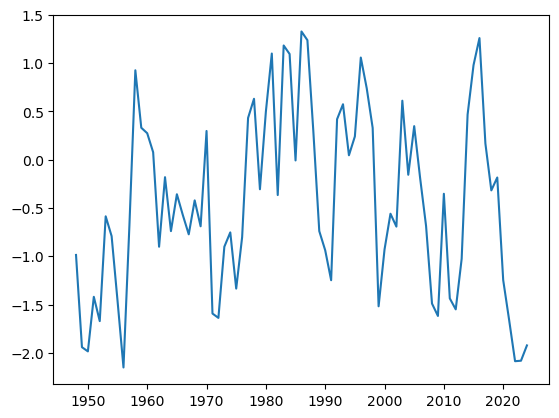

In [7]:
def read_pdo_csv(csv_string_or_filepath):
    """
    Reads a CSV string or file with the specified format into a Pandas DataFrame.

    Args:
        csv_string_or_filepath (str): The CSV string or the path to the CSV file.

    Returns:
        pd.DataFrame: The Pandas DataFrame containing the data.
    """
    try:
        # Try to read from a file path
        with open(csv_string_or_filepath, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        # Try to read from a string
        lines = csv_string_or_filepath.splitlines()

    # Skip the first line (header)
    data_lines = lines[1:]

    # Process the data
    data = []
    for line in data_lines:
        values = line.split()
        data.append(values)

    # Create the DataFrame
    df = pd.DataFrame(data[1:], columns=data[0])

    # Convert the 'Year' column to integer and the rest to float
    df['Year'] = pd.to_numeric(df['Year'])
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col])

    return df

df = read_pdo_csv('../SST_AOD/PDO.csv')
df.index=df.Year
df = df.iloc[:,1:]
df = df.loc[:2024]
pdo = df[['Jan','Feb','Mar','Apr','May','Dec']].mean(axis=1)
plt.plot(pdo.loc['1948':])


In [8]:
oni_index = pd.read_csv('../SST_AOD/oni-index.txt',sep=None,index_col=0,engine='python',names=np.arange(1,13))

In [9]:
oni = oni_index[[1,2,3,4,5,12]].mean(axis=1)

In [10]:
yearly_freq.rolling(30).mean()[2023]

19.05022831050228

In [11]:
pdo.loc['1948':].rolling(30).mean()[1982]

-0.4483888888888889

In [12]:
oni.loc['1948':].rolling(30).mean()[1982]

0.026111111111111123

In [13]:
oni.loc['1948':].rolling(30).mean()[2023]

-0.09666666666666666

# linear regression

In [14]:
pdo

Year
1854   -0.545000
1855   -0.605000
1856   -0.280000
1857   -0.875000
1858   -0.956667
          ...   
2020   -1.246667
2021   -1.660000
2022   -2.086667
2023   -2.081667
2024   -1.923333
Length: 171, dtype: float64

In [15]:
oni

1950   -1.183333
1951   -0.016667
1952    0.300000
1953    0.650000
1954   -0.050000
          ...   
2020    0.050000
2021   -0.816667
2022   -0.966667
2023    0.250000
2024    0.833333
Length: 75, dtype: float64

In [16]:
# hypothesis pt-freq = A + Bxpdo_index
y = copy.deepcopy(yearly_freq.loc['1950':'2023']).values
x1 = copy.deepcopy(pdo.loc['1950':'2023']).values
x2 = copy.deepcopy(oni.loc['1950':'2023']).values
# Stack x1 and x2 as columns -> shape (n_samples, n_features)
X = np.column_stack((x1, x2))
from sklearn.linear_model import LinearRegression

# Create and fit the model
model = LinearRegression(fit_intercept=True)
model.fit(X, y)
# Get results
intercept = model.intercept_
freq_no_pdo = y-model.predict(X)+intercept
freq_no_pdo = pd.DataFrame(freq_no_pdo,index=yearly_freq.loc['1950':'2023'].index,columns=['freq_no_pdo'])
# plt.plot(y)

In [17]:
pdo = (pdo.loc['1948':'2023']-np.mean(pdo.loc['1948':'2023']))/np.std(pdo.loc['1948':'2023'])
oni = (oni.loc['1948':'2023']-np.mean(oni.loc['1948':'2023']))/np.std(oni.loc['1948':'2023'])

In [18]:
yearly_freq_std = (yearly_freq-np.mean(yearly_freq))/np.std(yearly_freq)
yearly_freq_std = yearly_freq_std.loc['1948':'2023']

In [19]:
freq_no_pdo_std = (freq_no_pdo-np.mean(freq_no_pdo))/np.std(freq_no_pdo)
freq_no_pdo_std = freq_no_pdo_std.loc['1948':'2023']

/glade/work/jhayron/conda-envs/weather_regimes/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3571: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [20]:
def bootstrap_trend_confidence_intervals(series, n_bootstrap=1000, confidence_level=0.95):
    """
    Calculates the linear trend and confidence intervals using bootstrapping.

    Args:
        series (pd.Series): The Pandas time series.
        n_bootstrap (int): Number of bootstrap samples.
        confidence_level (float): Confidence level for the intervals.

    Returns:
        dict: A dictionary containing the trend, lower confidence interval, and upper confidence interval.
    """

    years = series.index.values
    values = series.values

    trends = []
    for _ in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(len(years), size=len(years), replace=True)
        years_resampled = years[indices]
        values_resampled = values[indices]

        # Calculate trend
        slope, _, _, _, _ = stats.linregress(years_resampled, values_resampled)
        trends.append(slope)

    # Calculate confidence intervals
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100

    lower_ci = np.percentile(trends, lower_percentile)
    upper_ci = np.percentile(trends, upper_percentile)

    # Calculate the trend on the original data.
    original_slope, _, _, _, _ = stats.linregress(years, values)

    return {
        'trend': original_slope*10,
        'lower_ci': lower_ci*10,
        'upper_ci': upper_ci*10
    }

In [21]:
bootstrap_trend_confidence_intervals(freq_no_pdo['freq_no_pdo'].rolling(30,center=True).mean().dropna().dropna())

{'trend': 1.588330505605525,
 'lower_ci': 1.2646451696884167,
 'upper_ci': 1.9319612057908762}

In [79]:
bootstrap_trend_confidence_intervals(yearly_freq.rolling(30,center=True).mean().dropna().dropna().loc['1965':'2009'])

{'trend': 1.6803412324555864,
 'lower_ci': 1.2121856548877499,
 'upper_ci': 2.203996827806678}

In [74]:
freq_no_pdo['freq_no_pdo'].rolling(30,center=True).mean().dropna().dropna()

year
1965    15.768196
1966    15.745717
1967    15.883135
1968    15.922209
1969    15.954877
1970    16.281015
1971    16.211080
1972    16.654720
1973    17.293299
1974    17.463747
1975    18.174642
1976    17.759387
1977    17.961199
1978    18.265363
1979    19.158042
1980    19.919867
1981    20.587471
1982    20.378529
1983    20.621166
1984    20.791437
1985    21.065141
1986    21.503801
1987    21.496212
1988    21.470991
1989    21.293641
1990    21.449321
1991    21.390869
1992    21.872335
1993    22.117459
1994    22.230948
1995    22.289850
1996    22.458861
1997    22.643418
1998    22.715440
1999    22.480052
2000    22.135225
2001    22.752169
2002    22.052914
2003    21.605901
2004    21.861954
2005    21.286718
2006    21.528531
2007    21.462028
2008    21.519863
2009    21.076945
Name: freq_no_pdo, dtype: float64

In [22]:
freq_no_pdo.to_csv('freq_no_pdo.csv')

In [23]:
# diff = yearly_freq_std - pdo - oni

In [24]:
pdo = (pdo.loc['1948':]-np.mean(pdo.loc['1948':]))/np.std(pdo.loc['1948':])
oni = (oni.loc['1948':]-np.mean(oni.loc['1948':]))/np.std(oni.loc['1948':])

Text(0.0, 1.0, '30-year-averaged time series: PT Freq., PDO, ONI')

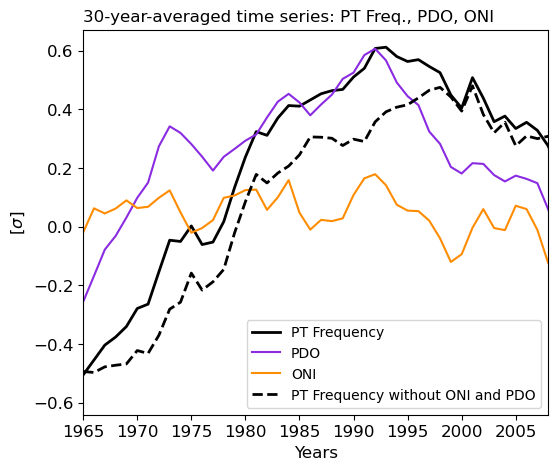

In [25]:
plt.figure(figsize=(6,5))

plt.plot(yearly_freq_std.rolling(30,center=True).mean(),color='k',label='PT Frequency',lw=2)
plt.plot(pdo.loc['1948':].rolling(30,center=True).mean(),color='blueviolet',label='PDO')
plt.plot(oni.loc['1948':].rolling(30,center=True).mean(),color='darkorange',label='ONI')
plt.plot(freq_no_pdo_std.loc['1948':].rolling(30,center=True).mean(),color='black',label='PT Frequency without ONI and PDO',ls='--',lw=2)
# plt.plot(meanghgcesm2.loc['1948':],color='green',label='PT Frequency CESM-SF GHG',ls='--')
# plt.plot(diffcesm2.loc['1948':],color='salmon',label='PT Frequency CESM-SF GHG+AER',ls='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('$[\sigma]$',fontsize=12)
plt.xlabel('Years',fontsize=12)
plt.xlim(1965,2008)
# plt.ylim(-1.5,1.5)
# plt.legend(bbox_to_anchor=(1, 1.), loc='upper left', borderaxespad=0.4)
plt.legend()
plt.title('30-year-averaged time series: PT Freq., PDO, ONI',loc='left')
# plt.savefig('../ScriptsFiguresPaper/Figures/6_PDO_ONI.png')

/glade/derecho/scratch/jhayron/tmp/ipykernel_63724/4200483296.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_temp = plt.subplot(1, 4, 1, projection=ccrs.PlateCarree(180))
/glade/derecho/scratch/jhayron/tmp/ipykernel_63724/4200483296.py:62: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_temp = plt.subplot(1, 4, 3, projection=ccrs.PlateCarree(180))
/glade/derecho/scratch/jhayron/tmp/ipykernel_63724/4200483296.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_temp = plt.subplot(1, 4, 4, projection=ccrs.PlateCarree(180))


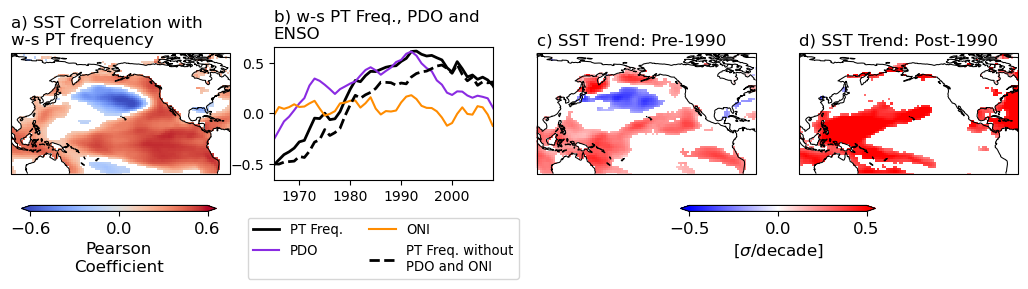

In [73]:
fontsize=12
fontsize_most_things=fontsize

fig, axs = plt.subplots(
        1, 4,
        figsize=(13, 4))

# fig, axs = plt.subplots(3, 3,figsize=(11,7), subplot_kw={'projection':ccrs.PlateCarree(180)})  # 2x2 grid of subplots
axs_list = axs.flatten().tolist()

##### SST corr ####
ax_temp = plt.subplot(1, 4, 1, projection=ccrs.PlateCarree(180))
intervals = 41
mini=-0.6
maxi=0.6
bounds=np.linspace(mini,maxi,intervals)
# print(vmax,vmin)
pm = ax_temp.pcolormesh(corr_sst.lon,corr_sst.lat,\
    corr_sst.correlation,cmap='coolwarm',
    transform=ccrs.PlateCarree(),
    vmin=mini,vmax=maxi)
ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)

# Set the boundary of the plot
ax_temp.set_extent([-80, 120, -30, 80], crs=ccrs.PlateCarree(180))
# ax_temp.margins(x=0, y=0)
# Add colorbar
ax_temp.set_title(f'a) SST Correlation with\nw-s PT frequency',loc='left',fontsize=fontsize)
# Add colorbar
cbar_ax = fig.add_axes([0.133, 0.25, 0.15, 0.015])
ticks_1 = [-0.6,0,0.6]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('Pearson\nCoefficient', fontsize=fontsize_most_things)


##### Time series #####

ax_temp= axs_list[1]


ax_temp.plot(yearly_freq_std.rolling(30,center=True).mean(),color='k',label='PT Freq.',lw=2)
ax_temp.plot(pdo.loc['1948':].rolling(30,center=True).mean(),color='blueviolet',label='PDO')
ax_temp.plot(oni.loc['1948':].rolling(30,center=True).mean(),color='darkorange',label='ONI')
ax_temp.plot(freq_no_pdo_std.loc['1948':].rolling(30,center=True).mean(),color='black',
             label='PT Freq. without\nPDO and ONI',ls='--',lw=2)
# plt.plot(meanghgcesm2.loc['1948':],color='green',label='PT Frequency CESM-SF GHG',ls='--')
# plt.plot(diffcesm2.loc['1948':],color='salmon',label='PT Frequency CESM-SF GHG+AER',ls='--')
ax_temp.set_aspect(20)
# ax_temp.set_xticks(fontsize=12)
# ax_temp.set_yticks(fontsize=12)
ax_temp.set_ylabel('$[\sigma]$',fontsize=fontsize_most_things)
# ax_temp.set_xlabel('Years',fontsize=fontsize_most_things)
ax_temp.set_xlim(1965,2008)
ax_temp.set_ylim(-0.65,0.65)
# plt.legend(bbox_to_anchor=(1, 1.), loc='upper left', borderaxespad=0.4)
ax_temp.set_title(f'b) w-s PT Freq., PDO and\nENSO',loc='left',fontsize=fontsize)
ax_temp.legend(bbox_to_anchor=(0.5, -0.8), loc='lower center', ncols=2,fontsize=9.5)

##### SST trend pre ####
ax_temp = plt.subplot(1, 4, 3, projection=ccrs.PlateCarree(180))
intervals = 41
mini=-0.5
maxi=0.5
bounds=np.linspace(mini,maxi,intervals)
# print(vmax,vmin)
pm = ax_temp.pcolormesh(sst_trend_pre.lon,sst_trend_pre.lat,\
    sst_trend_pre*10,cmap='bwr',
    transform=ccrs.PlateCarree(),
    vmin=mini,vmax=maxi)
ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
# ax_temp.margins(x=0, y=0)
# Add colorbar
ax_temp.set_extent([-80, 120, -30, 80], crs=ccrs.PlateCarree(180))
ax_temp.set_title(f'c) SST Trend: Pre-1990',loc='left',fontsize=fontsize)


##### SST trend post ####
ax_temp = plt.subplot(1, 4, 4, projection=ccrs.PlateCarree(180))
intervals = 41
mini=-0.5
maxi=0.5
bounds=np.linspace(mini,maxi,intervals)
# print(vmax,vmin)
pm = ax_temp.pcolormesh(sst_trend_post.lon,sst_trend_post.lat,\
    sst_trend_post*10,cmap='bwr',
    transform=ccrs.PlateCarree(),
    vmin=mini,vmax=maxi)
ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
# ax_temp.margins(x=0, y=0)
# Add colorbar
ax_temp.set_extent([-80, 120, -30, 80], crs=ccrs.PlateCarree(180))
ax_temp.set_title(f'd) SST Trend: Post-1990',loc='left',fontsize=fontsize)

# Add colorbar
cbar_ax = fig.add_axes([0.64, 0.25, 0.15, 0.015])
ticks_1 = [-0.5,0,0.5]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[$\sigma$/decade]', fontsize=fontsize_most_things)

# plt.tight_layout()
plt.savefig('nFigures/Corrs_SST.png',bbox_inches='tight')

/glade/derecho/scratch/jhayron/tmp/ipykernel_19906/516269856.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


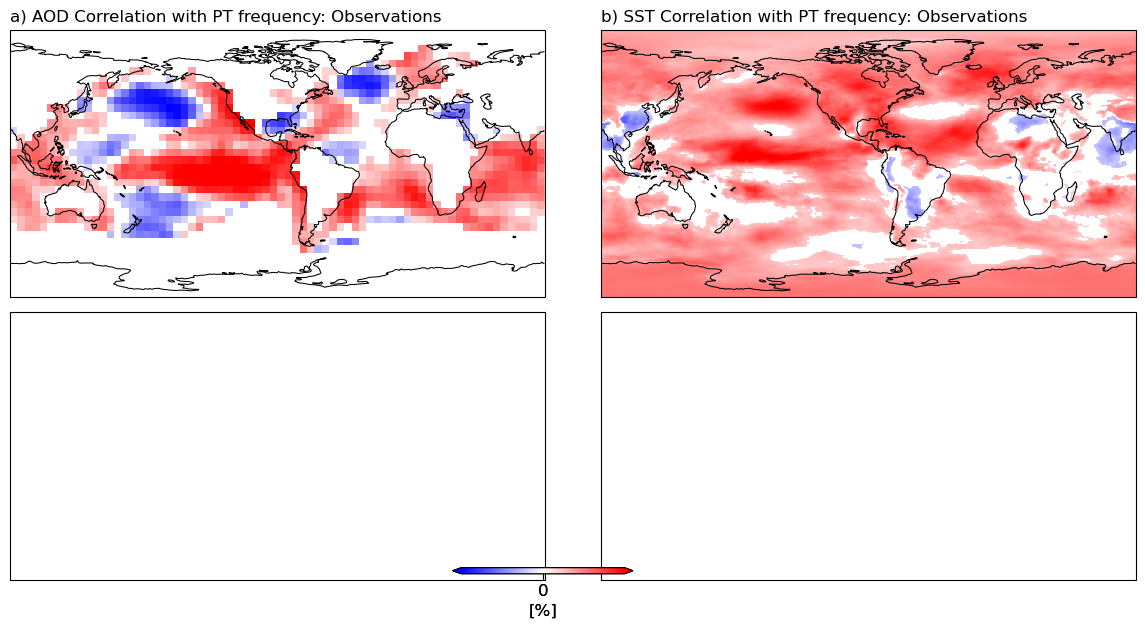

In [43]:
fontsize=12
fontsize_most_things=fontsize

fig, axs = plt.subplots(2, 2,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(270)})  # 2x2 grid of subplots
axs_list = axs.flatten().tolist()

##### Plot ####
ax_temp = axs_list[0]
intervals = 41
mini=-0.3
maxi=0.3
bounds=np.linspace(mini,maxi,intervals)
# print(vmax,vmin)
pm = ax_temp.pcolormesh(corr_sst.lon,corr_sst.lat,\
    corr_sst.correlation,cmap='bwr',
    transform=ccrs.PlateCarree(),
    vmin=mini,vmax=maxi)
ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
# ax_temp.margins(x=0, y=0)
# Add colorbar
cbar_ax = fig.add_axes([0.4, 0.035, 0.15, 0.01])
ticks_1 = [0,25,50,75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)
# Set geographical extent (lon_min, lon_max, lat_min, lat_max)

ax_temp.set_title(f'a) AOD Correlation with PT frequency: Observations',loc='left',fontsize=fontsize)

##### Plot ####
ax_temp = axs_list[1]
intervals = 41
mini=-0.3
maxi=0.3
bounds=np.linspace(mini,maxi,intervals)
# print(vmax,vmin)
pm = ax_temp.pcolormesh(corr_aod.lon,corr_aod.lat,\
    corr_aod.correlation,cmap='bwr',
    transform=ccrs.PlateCarree(),
    vmin=mini,vmax=maxi)
ax_temp.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
# ax_temp.margins(x=0, y=0)
# Add colorbar
cbar_ax = fig.add_axes([0.4, 0.035, 0.15, 0.01])
ticks_1 = [0,25,50,75]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:],
                orientation='horizontal', extend='both')
cbar.ax.tick_params(labelsize=fontsize_most_things)
cbar.set_label('[%]', fontsize=fontsize_most_things)
# Set geographical extent (lon_min, lon_max, lat_min, lat_max)

ax_temp.set_title(f'b) SST Correlation with PT frequency: Observations',loc='left',fontsize=fontsize)

plt.tight_layout()



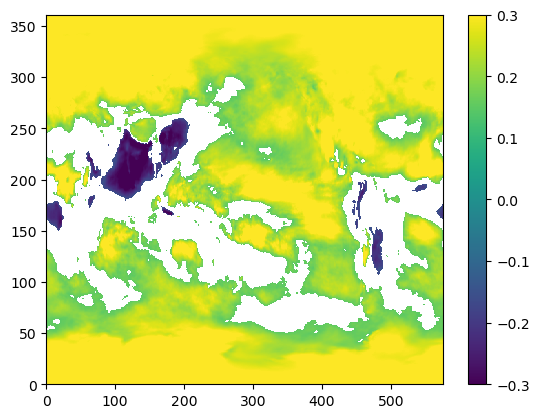

In [12]:
plt.pcolormesh(shift_longitude_to_0_360(corr_aod).correlation,vmin=-0.3,vmax=0.3)
plt.colorbar()